In [1]:
import theano.tensor as T 
import theano
import numpy
from theano.tensor.nnet import relu,conv2d
import h5py
from theano.tensor.signal.pool import pool_2d
import numpy as np
from scipy.optimize import minimize
%matplotlib inline
import matplotlib.pyplot as plt

Using gpu device 0: GRID K520 (CNMeM is disabled, cuDNN 5005)


In [2]:
class ConvLayer(object):
	"""Convolutional layer"""

	def __init__(self, rng, input, filter_shape, image_shape, W=None, b=None, padding=(1,1),filter_flip=True):
		"""
		Allocate a LeNetConvPoolLayer with shared variable internal parameters.

		:type rng: numpy.random.RandomState
		:param rng: a random number generator used to initialize weights

		:type input: theano.tensor.dtensor4
		:param input: symbolic image tensor, of shape image_shape

		:type filter_shape: tuple or list of length 4
		:param filter_shape: (number of filters, num input feature maps,
		                      filter height, filter width)

		:type W: in accordance to filter_shape
		:param: use pretrained VGG weights

		:type b: (filter_shape[0],)
		:param: use pretrained vgg weights

		:type image_shape: tuple or list of length 4
		:param image_shape: (batch size, num input feature maps,
		                     image height, image width)

		:type padding: tuple or list of length 2
		:param padding: padding for conv
		"""

		#assert image_shape[1] == filter_shape[1]
		self.input = input

		if W is None:
			# there are "num input feature maps * filter height * filter width"
			# inputs to each hidden unit
			fan_in = numpy.prod(filter_shape[1:])
			# each unit in the lower layer receives a gradient from:
			# "num output feature maps * filter height * filter width" /
			#   pooling size
			fan_out = (filter_shape[0] * numpy.prod(filter_shape[2:]))
			# initialize weights with random weights
			W_bound = numpy.sqrt(6. / (fan_in + fan_out))
			self.W = theano.shared(
			    numpy.asarray(
			        rng.uniform(low=-W_bound, high=W_bound, size=filter_shape),
			        dtype=theano.config.floatX), borrow=True)
		else:
			self.W = theano.shared(W,borrow=True)

		if b is None:
			pass
		else:
			self.b = theano.shared(b,borrow=True)
        # convolve input feature maps with filters
		conv_out = conv2d(
		    input=input,
		    filters=self.W,
		    filter_shape=filter_shape,
		    input_shape=image_shape,
		    border_mode=padding,
            filter_flip=filter_flip
		)

		# add the bias term. Since the bias is a vector (1D array), we first
		# reshape it to a tensor of shape (1, n_filters, 1, 1). Each bias will
		# thus be broadcasted across mini-batches and feature map
		# width & height
		if b is None:
				self.output = relu(conv_out)
		else:
				self.output = relu(conv_out + self.b.dimshuffle('x', 0, 'x', 'x'))

In [3]:
def preprocessMap(im):
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    im = im[::-1, :, :]
    return np.float32(im[np.newaxis])

In [39]:
#load image
cImage = plt.imread('extra/Renoir.jpg')
shape = cImage.shape
cMap = plt.imread('extra/Landscape_sem.png')
cMap = preprocessMap(cMap)

aImage = plt.imread('extra/Renoir.jpg')
aImage = skimage.transform.resize(aImage,shape)*255
aMap = plt.imread('extra/Renoir_sem.png')
aMap = skimage.transform.resize(aMap,shape)
aMap = preprocessMap(aMap)

In [40]:
image = T.tensor3('image')
mapIm = T.tensor4('map')
mode = 'average_exc_pad'

#load the weights data
vgg_weights = h5py.File("vgg19_weights.h5")

image1 = image.reshape((1,shape[0],shape[1],3))
image2 = np.transpose(image1,(0,3,1,2))

#build the model
rng = numpy.random.RandomState(8888)
g = vgg_weights['layer_1']
conv1_1 = ConvLayer(rng=rng, input=image2, filter_shape=(64,3,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_3']
conv1_2 = ConvLayer(rng=rng, input=conv1_1.output,filter_shape=(64,64,3,3), image_shape=None,
	W=g['param_0'].value,b=g['param_1'].value, padding=(1,1))
conv1_pool = pool_2d(conv1_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_6']
conv2_1 = ConvLayer(rng=rng, input=conv1_pool, filter_shape=(128,64,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_8']
conv2_2 = ConvLayer(rng=rng, input=conv2_1.output, filter_shape=(128,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv2_pool = pool_2d(conv2_2.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

g = vgg_weights['layer_11']
conv3_1 = ConvLayer(rng=rng, input=conv2_pool, filter_shape=(256,128,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_13']
conv3_2 = ConvLayer(rng=rng, input=conv3_1.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_15']
conv3_3 = ConvLayer(rng=rng, input=conv3_2.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_17']
conv3_4 = ConvLayer(rng=rng, input=conv3_3.output, filter_shape=(256,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
conv3_pool = pool_2d(conv3_4.output,ds=(2,2),padding=(0,0),mode=mode,ignore_border=True)

#use pool layer to downsample
mapIm3 = pool_2d(mapIm,ds=(4,4),mode='average_exc_pad',ignore_border=True)

g = vgg_weights['layer_20']
conv4_1 = ConvLayer(rng=rng, input=conv3_pool, filter_shape=(512,256,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))
g = vgg_weights['layer_22']
conv4_2 = ConvLayer(rng=rng, input=conv4_1.output, filter_shape=(512,512,3,3), image_shape=None, 
	W=g['param_0'].value ,b=g['param_1'].value, padding=(1,1))

#mapImage
mapIm4 = pool_2d(mapIm,ds=(8,8),mode='average_exc_pad',ignore_border=True)

In [41]:
#choose layers
cLayers = [conv4_2]
aLayers = [conv3_1,conv4_1]
mLayers = [mapIm3,mapIm4]
#use theano concatenate function to combine two layers
combineLayers = [T.concatenate([a.output,b],axis=1) for 
                     a,b in zip(aLayers,mLayers)]

In [42]:
#extract patches
def getPatch(im,size=(3,3),st=(1,1)):
    a = T.nnet.neighbours.images2neibs(im,size,st,mode='valid')
    a = a.reshape((-1,a.shape[0]//im.shape[1],size[0],size[1])).dimshuffle((1, 0, 2, 3))
    return a

In [44]:
#get combine layers result for style image
combineResult = theano.function(inputs=[image,mapIm],outputs=[a for a in combineLayers],allow_input_downcast=True)
#save result for style image
aCombine = combineResult(aImage,aMap)
aCombine = [theano.shared(a) for a in aCombine]
#patches result for art input 
aPatches = [getPatch(a.get_value()) for a in aCombine]

In [45]:
#hyperparameters
aRatio = 1
cRatio = 1
sWeight = 100

In [46]:
def compute_norms(patches):
    #helper function to compute norms for M and N layers separately
    ni = T.sqrt(T.sum(patches[:,:-3] ** 2.0, axis=(1,), keepdims=True))
    ns = T.sqrt(T.sum(patches[:,-3:] ** 2.0, axis=(1,), keepdims=True))
    return [ni] + [ns] 
def normalize_components(patches, norms):
    #normlize the concat layer
    return T.concatenate([patches[:,:-3] / (norms[0]),
                          sWeight*patches[:,-3:] / (norms[1])],
                         axis=1)

In [64]:
nnOutputs = []

#symbolic combine layer representation for image

for clayer, apatch in zip(combineLayers,aPatches):
    n1 = normalize_components(apatch,compute_norms(apatch))
    ipatch = getPatch(clayer)
    n2 = normalize_components(ipatch,compute_norms(ipatch))
    #flatten result to do dot
    a = n2.flatten(2)
    b = n1.flatten(2)
    #extract the nearest neighbor
    r = T.argmax(T.dot(a,b.T),axis=1)
    nnOutputs.append(apatch[r])

#symbolic representation for patches
iPatches = [getPatch(a.output) for a in aLayers]

#art loss
aLosses = [aRatio*T.mean((a - b[:,:-3]) ** 2.0) 
                for a,b in zip(iPatches,nnOutputs)]

In [65]:
#content_loss
cLosses = []
if cLayers!=[]:
    f = theano.function(inputs=[image],outputs=[conv4_2.output])
    cLosses = [cRatio*T.sum((f(cImage)[0] - conv4_2.output) ** 2.0)]

#total loss
totalLoss = T.sum(cLosses + aLosses)

In [66]:
#the following part is the same as the first one
grad = T.grad(totalLoss, image)
theanoLoss = theano.function([image,mapIm], totalLoss, allow_input_downcast=True)
theanoGrad = theano.function([image,mapIm], grad, allow_input_downcast=True)

In [71]:
def sciLoss(x):
    x = np.float32(x.reshape(shape))
    inputImage.set_value(x)
    return theanoLoss(inputImage.get_value(),cMap).astype('float64')

def sciGrad(x):
    x = np.float32(x.reshape(shape))
    inputImage.set_value(x)
    return np.ravel(theanoGrad(inputImage.get_value(),cMap)).astype('float64')

In [ ]:
#initialize an image
initialImage = np.random.uniform(-126.0,127.0,size=(shape[0],shape[1],3))
inputImage = theano.shared(np.asarray(initialImage,dtype='float32'),borrow=True)

n_epochs = 3
for epoch in xrange(n_epochs):
    print epoch
    minimize(fun=sciLoss, x0=np.ravel(inputImage.get_value()).astype('float64'), jac=sciGrad,
         method='L-BFGS-B',options={'disp':True,'maxfun':40,'maxiter':15000})
    print theanoLoss(inputImage.get_value(),cMap)


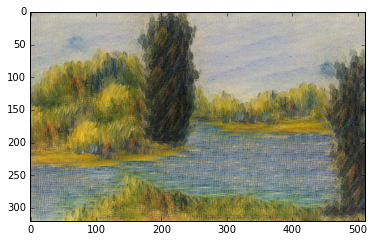

In [76]:
#plot the image
plt.imshow(np.clip(inputImage.get_value(), 0, 255).astype('uint8'))